In [29]:
from google.colab import drive
drive.mount('/content/drive')

import os
# Changing the directory
os.chdir("/content/drive/MyDrive/Colab Notebooks/Animal Detection")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='step1'></a>
## Step 1: Import Dataset and Libraries

Our fist step is to import all the libraries used in this project.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import os
import re
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
from skimage import io
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
from torch.utils.data import (Dataset, DataLoader)  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torchvision.models as models

## Visualize the data

First lets examine the files.
- Which are the species?
- How many pictures do we have from each animal?



In [ ]:
animals_list = os.listdir("animals")
animals_file_list = []

for i in range(len(animals_list)):
  animals_file_list.append(os.listdir(str("animals/" + animals_list[i])))
  n = len(animals_file_list[i])
  print('There are', n , animals_list[i] , 'images.')

There are 59 bear images.
There are 60 cat images.
There are 59 dog images.
There are 59 lion images.
There are 59 wolf images.


Apparently we have a balanced dataset,  which means we have a similar but not equal proportion of images of animals from each species.
To have a more real notion.






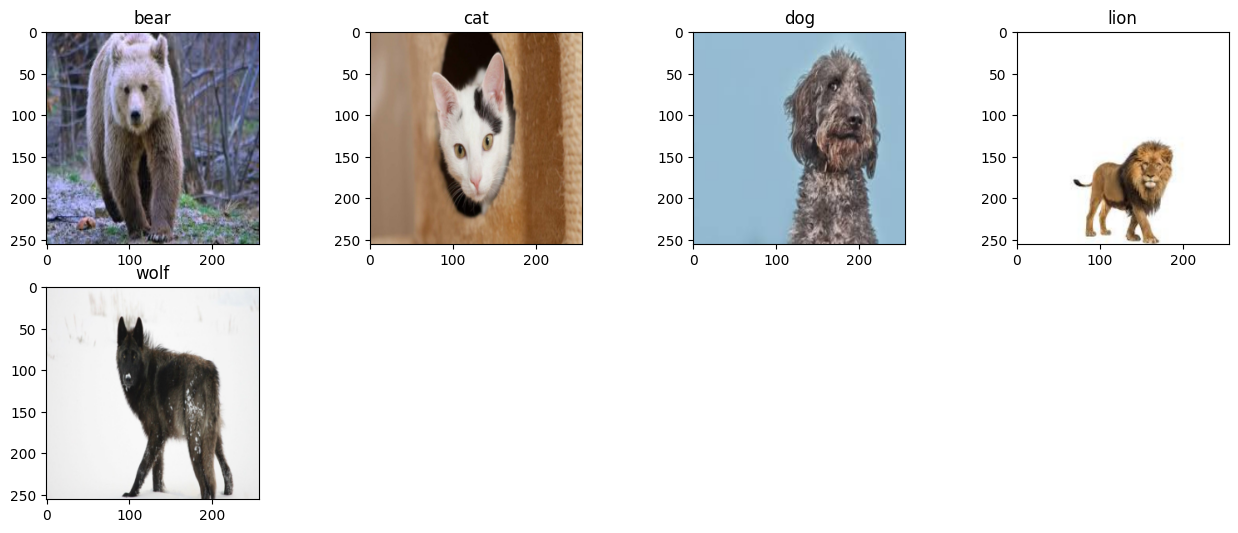

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5

for i in range(1, len(animals_list)+1):
    img = mpimg.imread(str("animals/"+ animals_list[i-1] + "/"+ animals_file_list[i-1][0]))
    compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256))])
    img = compose(img)
    fig.add_subplot(rows, columns, i)
    plt.axis('on')
    plt.title(animals_list[i-1])
    plt.imshow(img)
plt.show()

Very beautiful animals right?

## Load Data

Now we will make use of Pytorch elements `transform`, `ImageFolder`, `DataLoader` to load the data.

The next steps will be the following.

1. Create a dataframe with the name of each file, the animal and the absolute path.
2. Select files that will further be in the train, test and validation sets.
3. Perform transformation in the data such as reshaping, croping and rotation that will allow the images that are from different sizes to be analyzed together.
4. Load the datasets using the DataLoader function, that will transform the images in tensors that will be analysed by the CNN.

In [ ]:
dir = 'animals/'
files = [f for f in glob(dir + "**/**", recursive=True)] # create a list will all absolute path of all files
print(files)

['animals/', 'animals/bear', 'animals/bear/048d7b29e3.jpg', 'animals/bear/039b2ae790.jpg', 'animals/bear/08e665796d.jpg', 'animals/bear/04e5d04320.jpg', 'animals/bear/090234b385.jpg', 'animals/bear/093836b753.jpg', 'animals/bear/0f61069510.jpg', 'animals/bear/0e6a8744de.jpg', 'animals/bear/116d9b7f88.jpg', 'animals/bear/1971d6e226.jpg', 'animals/bear/1b890605d5.jpg', 'animals/bear/1ebb88dff2.jpg', 'animals/bear/1eda26b7f5.jpg', 'animals/bear/25ad0adb55.jpg', 'animals/bear/22ea4eea68.jpg', 'animals/bear/561c2bfe97.jpg', 'animals/bear/5687a6bcec.jpg', 'animals/bear/5db7b4c807.jpg', 'animals/bear/5f0ccad194.jpg', 'animals/bear/5dfb1c44b4.jpg', 'animals/bear/6bee43b688.jpg', 'animals/bear/6d4f05236d.jpg', 'animals/bear/6da5c2a437.jpg', 'animals/bear/7ad4697892.jpg', 'animals/bear/7c4f6d1f97.jpg', 'animals/bear/831f7bd81b.jpg', 'animals/bear/86581a8ae9.jpg', 'animals/bear/87a4b68284.jpg', 'animals/bear/8ab6a06ff9.jpg', 'animals/bear/8cf44a21ba.jpg', 'animals/bear/8ded9df224.jpg', 'animals/b

In [ ]:
df_animals = pd.DataFrame({"file_path":files}) # transform in a dataframe
df_animals['animal'] = df_animals['file_path'].str.extract('animals/(.+)/') # extract the name of the animal
df_animals['file'] = df_animals['file_path'].str.extract('animals/.+/(.+)') # extrat the file name
df_animals = df_animals.dropna() # drop Neural Architecture Search (NAS) refers to using machine learning techniques to automatically design neural network architectures.

print(df_animals)

                       file_path animal            file
2    animals/bear/048d7b29e3.jpg   bear  048d7b29e3.jpg
3    animals/bear/039b2ae790.jpg   bear  039b2ae790.jpg
4    animals/bear/08e665796d.jpg   bear  08e665796d.jpg
5    animals/bear/04e5d04320.jpg   bear  04e5d04320.jpg
6    animals/bear/090234b385.jpg   bear  090234b385.jpg
..                           ...    ...             ...
598  animals/wolf/996fb0a526.jpg   wolf  996fb0a526.jpg
599  animals/wolf/9a059979c1.jpg   wolf  9a059979c1.jpg
600  animals/wolf/9aaeb59193.jpg   wolf  9aaeb59193.jpg
601  animals/wolf/9c3db9d85d.jpg   wolf  9c3db9d85d.jpg
602  animals/wolf/9cdcad3179.jpg   wolf  9cdcad3179.jpg

[592 rows x 3 columns]


Now we split the data in train, test and validation (inside the dataframe).

In [ ]:
animal_set = set(df_animals['animal'])
train_val_test_list = [0,1,2]
train_val_weights = [70,15,15]
df_animals['train_val_test'] = 'NA'

for an in animal_set:
  n = sum(df_animals['animal'] == an) # count the number of animals
  train_val_test = random.choices(train_val_test_list, weights= train_val_weights,  k=n)
  df_animals.loc[df_animals['animal'] == an, 'train_val_test'] = train_val_test

Now we will create the dictonary `transform`. it will be used to transform the train, test and validation datasets.
We will apply different transformations on the train and test/validation datasets. Data augmentation is used in the trainning dataset to avoid overfitting, that means to avoid the a very good performance on the trainning set but a bed performane on the validation and testing datasets (bed generalization). The methods used were:
- Flipping the images horizontally
- Random Cropping: Extract randomly a 224 × 224 pixels section from 256 × 256 pixels
- RandomRotation: Randomly rotate the image by 10 degrees.


In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}


We create an auxiliary function to make sure the data is correctly splited among train, test and validation.   

In [ ]:
def check_train(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 0).bool

def check_valid(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 1).bool

def check_test(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 2).bool


#### Load the dataset

In [ ]:
# Reading Dataset
image_datasets = {
    'train' : ImageFolder(root= dir, transform=transform['train'], is_valid_file=check_train),
    'valid' : ImageFolder(root=dir, transform=transform['valid'], is_valid_file=check_valid),
    'test' : ImageFolder(root=dir, transform=transform['test'], is_valid_file=check_test)
}

In [ ]:
num_workers = 0
batch_size = 20

loaders_scratch = {
    'train' : DataLoader(image_datasets['train'], shuffle = True, batch_size = batch_size),
    'valid' : DataLoader(image_datasets['valid'], shuffle = True, batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'], shuffle = True, batch_size = batch_size)
}

#### USE GPU

In [ ]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

<a id='step2'></a>
## Step 2: Create a CNN to Classify Wild Animals (from Scratch)

We create a CNN that reveives tensors of `224 x 224 x 3` dimensions (that's how we prepared the dataset).

Some of the elements of our network built from scratch.
- Five convolutional layers. The last will return a tensor of `128 x 256, x 3` dimensions. Padding equals 1.
- A relu function applied after every convolutional iteration.
- A pooling function applied after every convolutional iteration.
- Two dropout layers to avoid overffiting.
- Two fully connected layers.  




 that will transform `128 x 256 x 3`
- relu


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 122 x 122 x 16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28 x 28 x 64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14 x 14 x 128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        # linear layer (64 * 4 * 4 -> 133)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (133 -> 133)
        self.fc2 = nn.Linear(512, 20)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn5(self.pool(F.relu(self.conv4(x))))
        x = self.conv_bn6(self.pool(F.relu(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6

We define an optmizer and a loss function.

- **loss function**: Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0. From the [ml-cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

- **optimizer**: Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the computational burden, achieving faster iterations in trade for a lower convergence rate. From [wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [ ]:

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizerx
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)


        ######################
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)


        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss

    # return trained model
    return model

# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 2.661744 	Validation Loss: 2.642241
Validation loss decreased (inf --> 2.642241).  Saving model ...
Epoch: 2 	Training Loss: 1.611642 	Validation Loss: 1.661863
Validation loss decreased (2.642241 --> 1.661863).  Saving model ...
Epoch: 3 	Training Loss: 1.415686 	Validation Loss: 1.380859
Validation loss decreased (1.661863 --> 1.380859).  Saving model ...
Epoch: 4 	Training Loss: 1.374155 	Validation Loss: 1.159498
Validation loss decreased (1.380859 --> 1.159498).  Saving model ...
Epoch: 5 	Training Loss: 1.236488 	Validation Loss: 1.106506
Validation loss decreased (1.159498 --> 1.106506).  Saving model ...
Epoch: 6 	Training Loss: 1.156674 	Validation Loss: 1.004844
Validation loss decreased (1.106506 --> 1.004844).  Saving model ...
Epoch: 7 	Training Loss: 1.109447 	Validation Loss: 0.892381
Validation loss decreased (1.004844 --> 0.892381).  Saving model ...
Epoch: 8 	Training Loss: 1.176859 	Validation Loss: 0.842292
Validation loss decreased (0.89238

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    if torch.cuda.is_available():
      model.cuda()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.426729


Test Accuracy: 86% (255/296)


<a id='step3'></a>
## Step 3: Create a CNN to Classify Wild Animals (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify the animals from the images.


*VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.*










In [ ]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

In [ ]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# train the model
model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.004036 	Validation Loss: 2.562158
Validation loss decreased (inf --> 2.562158).  Saving model ...
Epoch: 2 	Training Loss: 2.279407 	Validation Loss: 1.341257
Validation loss decreased (2.562158 --> 1.341257).  Saving model ...
Epoch: 3 	Training Loss: 1.488359 	Validation Loss: 0.807858
Validation loss decreased (1.341257 --> 0.807858).  Saving model ...
Epoch: 4 	Training Loss: 0.935673 	Validation Loss: 0.539539
Validation loss decreased (0.807858 --> 0.539539).  Saving model ...
Epoch: 5 	Training Loss: 0.706021 	Validation Loss: 0.404878
Validation loss decreased (0.539539 --> 0.404878).  Saving model ...
Epoch: 6 	Training Loss: 0.656974 	Validation Loss: 0.323817
Validation loss decreased (0.404878 --> 0.323817).  Saving model ...
Epoch: 7 	Training Loss: 0.546249 	Validation Loss: 0.269695
Validation loss decreased (0.323817 --> 0.269695).  Saving model ...
Epoch: 8 	Training Loss: 0.524973 	Validation Loss: 0.230889
Validation loss decreased (0.26969

In [ ]:
model_transfer.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.069874


Test Accuracy: 98% (292/296)


In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the animal that is predicted by the model.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import random
import re

# create a list with a class names
class_names = image_datasets['train'].classes
class_names = [re.sub("\d{3}.", "", item) for item in class_names]
class_names = [re.sub("_", " ", item) for item in class_names]

def predict_breed_transfer(img_path):

    # load the image and return the predicted breed
    img = Image.open(img_path) # Load the image from provided path

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize]
    )

    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable

    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())

    model_transfer.eval()
    output = model_transfer(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()

    # Our prediction will be the index of the class label with the largest value.
    predict_index = output.data.numpy().argmax()

    predicted_breed = class_names[predict_index]
    true_breed = image_datasets['train'].classes[predict_index]

    return (predicted_breed, true_breed)

# Create list of test image paths
test_img_paths = list(df_animals[df_animals.train_val_test == 2].file_path)
np.random.shuffle(test_img_paths)

for img_path in test_img_paths[0:20]:
    predicted_breed, true_breed = predict_breed_transfer(img_path)
    print("Predicted Animal:" , predicted_breed, "\n", "True Animal:" , true_breed)
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [30]:
import os
torch.load('model_scratch.pt')

# Define the path to the folder containing the images
folder_path = './test'

# Get a list of all files (images) in the folder
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Iterate through each image file
for img_path in image_files:
    # Call the predict_breed_transfer function to get predictions
    predicted_breed, true_breed = predict_breed_transfer(img_path)

    # Print the predicted and true breed
    print("Predicted Animal:", predicted_breed, "\n", "True Animal:", true_breed)

    # Display the image
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.